# Weight Initialization


Trong chương này, chúng ta sẽ tìm hiểu về cách khởi tạo weight (weight initialization). Dường như cách khởi tạo weight mặc định của PyTorch không còn phù hợp nữa, và LLAMA2 đã thay đổi cách thức khởi tạo weight. Vì vậy, chúng ta sẽ đi sâu để hiểu tại sao điều này cần thiết và việc thay đổi khởi tạo weight này sẽ có tác dụng gì.

In [1]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from datasets import load_dataset
import torch.nn.functional as F
from einops import rearrange # einstein operation

In [2]:
class ModelArgs:
    def __init__(self, vocab_size):
        
        self.max_sequence_len = 10
        self.multiple_of = 5

        self.rotary_dim = 3
        self.n_layer = 4
        self.batch_size = 16
        self.n_head = 4
        self.n_embd = 36
        self.vocab_size = vocab_size

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
vocab_size = tokenizer.vocab_size

args = ModelArgs(vocab_size)

In [3]:
sample = 50

dataset = load_dataset("roneneldan/TinyStories")
tokenizer.pad_token = tokenizer.eos_token  

subset_dataset = dataset['train'][:sample]['text']

tokenized_dataset = tokenizer(
    subset_dataset,
    return_tensors='pt',
    padding='max_length',  # Pad sequences to the max_seq_length
    truncation=True,  # Truncate sequences if they exceed max_seq_length
    max_length=args.max_sequence_len  # Set the maximum sequence length
)

data = tokenized_dataset['input_ids']
data.shape

Repo card metadata block was not found. Setting CardData to empty.


torch.Size([50, 10])

Để việc thử nghiệm thuận tiện hơn, tôi đã giảm độ dài chuỗi (sequence length) xuống còn 10. Điều này sẽ giúp quá trình vẽ biểu đồ kết quả diễn ra nhanh chóng hơn.

In [4]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

custom_dataset = CustomDataset(data)
data_loader = DataLoader(custom_dataset, batch_size=args.batch_size, shuffle=True)

input_ids = next(iter(data_loader))

# xb = input_ids[:, :-1].contiguous()
# yb = input_ids[:, 1:].contiguous()
# xb.shape, yb.shape
input_ids.shape

torch.Size([16, 10])

Từ đầu chương đến nay, chúng ta chỉ lấy dữ liệu một cách ngẫu nhiên. Bây giờ, tôi đã đưa dữ liệu vào data loader để có thể trích xuất dữ liệu theo từng batch, đồng thời vẫn giữ toàn bộ dữ liệu. Thay vì chia dữ liệu thành xb và yb, tôi giữ nguyên và gọi chúng là input_ids. Sau đó, ở giai đoạn tính loss, tôi sẽ tách logits ra thành x và y để tính toán loss.

## Not New

### Embedding

In [5]:
class Embedding(nn.Module):
    def __init__(self, args:ModelArgs):
        super().__init__()
        self.wte = nn.Embedding(args.vocab_size, args.n_embd)
        
    def forward(self, input_ids):
        input_shape = input_ids.shape[-1]
        input_ids = input_ids.view(-1, input_shape)
        
        input_ids_embd = self.wte(input_ids)
        
        return input_ids_embd
    
embd = Embedding(args)
input_ids_embd = embd(input_ids)
input_ids_embd.shape

torch.Size([16, 10, 36])

In [6]:
class RotaryEmbedding(nn.Module):
    def __init__(self, args:ModelArgs, base = 10000):
        super().__init__()
        self.rotary_dim  = args.rotary_dim
        
        inv_freq = 1.0 / (base ** (torch.arange(0, self.rotary_dim, 2) / self.rotary_dim ))
        self.register_buffer("inv_freq", inv_freq)
        
        self.cos_cache = None
        self.sin_cache = None
        
    def forward(self, qkv):
        seqlen = qkv.shape[1]
        
        # Update cos sin cache
        t = torch.arange(seqlen)
        freqs = torch.outer(t, self.inv_freq)
        
        self.cos_cache = torch.cos(freqs)
        self.sin_cache = torch.sin(freqs)
        
        # Apply rotary qkv
        rotary_dim = self.cos_cache.shape[1]
        rotary_dim *= 2
        
        q_rot = qkv[:, :, 0, :, :rotary_dim]
        q_pass = qkv[:, :, 0, :, rotary_dim:]
        
        k_rot = qkv[:, :, 1, :, :rotary_dim]
        k_pass = qkv[:, :, 1, :, rotary_dim:]
        
        # Splits the queries and keys in half
        q1, q2 = q_rot.chunk(2, dim=-1)
        k1, k2 = k_rot.chunk(2, dim=-1)
        c, s = rearrange(self.cos_cache, "t d -> t 1 d"), rearrange(self.sin_cache, "t d -> t 1 d")
        
        # Computes the new keys and queries
        q_rot = torch.cat([q1 * c - q2 * s, q1 * s - q2 * c], dim=-1)
        k_rot = torch.cat([k1 * c - k2 * s, k1 * s - k2 * c], dim = -1)
        
        return torch.cat(
            [
                torch.cat([q_rot, q_pass], dim=-1).unsqueeze(2),
                torch.cat([k_rot, k_pass], dim=-1).unsqueeze(2),
                qkv[:, :, 2:3, :, :]
            ],
            dim=2
        )

### RMS Norm

In [9]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight
    
attn_norm = RMSNorm(args.n_embd)
input_ids_embd_norm = attn_norm(input_ids_embd)
input_ids_embd_norm.shape

torch.Size([16, 10, 36])

### Self Attention

In [10]:
class Attention(nn.Module):
    def __init__(self, args:ModelArgs):
        super().__init__()
        
        self.rotary_emb = RotaryEmbedding(args)
        
        self.head_dim = args.n_embd // args.n_head
        opt_size = args.n_head * self.head_dim
        hidden_size = args.n_embd
        
        self.Wqkv = nn.Linear(hidden_size, 3 * opt_size)
        self.out_proj = nn.Linear(opt_size, hidden_size)
        
    def forward(self, input_ids_embd_norm):
        qkv = self.Wqkv(input_ids_embd_norm)
        qkv = rearrange(qkv, 'b t (three h d) -> b t three h d', three=3, d=self.head_dim)

        # Rotary Query & Key
        qkv = self.rotary_emb(qkv)
        q, k, v = qkv.unbind(2)
        
        output = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        output = rearrange(output, "... h d -> ... (h d)")

        attn_out = self.out_proj(output)
        
        return attn_out
    
# Normalize
attn_norm = RMSNorm(args.n_embd)
x_embd_norm = attn_norm(input_ids_embd)

attn = Attention(args)
attn_out = attn(input_ids_embd_norm)
# add residual
attn_out += input_ids_embd
attn_out.shape

torch.Size([16, 10, 36])

### Feed Forward

In [11]:
class FeedForward(nn.Module):
    def __init__(self, args:ModelArgs):
        super().__init__()
        hidden_dim = 4 * args.n_embd
        hidden_dim = int(2 * hidden_dim / 3)
        hidden_dim = args.multiple_of * ((hidden_dim + args.multiple_of - 1) // args.multiple_of)
        
        self.w1 = nn.Linear(args.n_embd, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, args.n_embd, bias=False)
        self.w3 = nn.Linear(args.n_embd, hidden_dim, bias=False)
        
        self.act = nn.SiLU()
        
    def forward(self, attn_out_norm):
        hidden_states = self.w1(attn_out_norm) * self.w3(attn_out_norm)
        hidden_states = self.act(hidden_states)
        ffwd_out = self.w2(hidden_states)
        
        return ffwd_out
    
# Normalize
ffwd_norm = RMSNorm(args.n_embd)
attn_out_norm = ffwd_norm(attn_out)

ffwd = FeedForward(args)
ffwd_out = ffwd(attn_out_norm)
# add residual
ffwd_out += attn_out
ffwd_out.shape

torch.Size([16, 10, 36])

### Transformer Block

In [12]:
class TransfomerBlock(nn.Module):
    def __init__(self, args:ModelArgs):
        super().__init__()
        
        self.attention_norm = RMSNorm(args.n_embd)
        self.ffwd_norm = RMSNorm(args.n_embd)
        
        self.attn = Attention(args)
        self.ffwd = FeedForward(args)
        
    def forward(self, input_ids_embd):
        
        attn_out = input_ids_embd + self.attn(self.attention_norm(input_ids_embd))
        
        ffwd_out = attn_out + self.ffwd(self.ffwd_norm(attn_out))
        
        return ffwd_out
    
t_block = TransfomerBlock(args)
ffwd_out = t_block(input_ids_embd)
ffwd_out.shape

torch.Size([16, 10, 36])

### Transformer

In [13]:
class TransformerHead(nn.Module):
    def __init__(self, args:ModelArgs):
        super().__init__()
        
        self.norm = RMSNorm(args.n_embd)
        self.linear = nn.Linear(args.n_embd, args.vocab_size)
        
    def forward(self, ffwd_out):
        h = self.norm(ffwd_out)
        logits = self.linear(h)
        
        return logits
    
t_head = TransformerHead(args)
logits = t_head(ffwd_out)
logits.shape

torch.Size([16, 10, 50257])

In [14]:
class TransformerSequential(nn.Module):
    def __init__(self, args:ModelArgs):
        super().__init__()
        
        modules = [Embedding(args)]
        modules += [TransfomerBlock(args) for _ in range(args.n_layer)]
        modules.append(TransformerHead(args))
        
        self.layers = nn.Sequential(*modules)
        
    def forward(self, input_ids):
        return self.layers(input_ids)
    
model = TransformerSequential(args)
logits = model(input_ids)
logits.shape

torch.Size([16, 10, 50257])

Từ đầu đến nay gần như là tôi chỉ sao chép code từ chương trước sang thôi, không có gì mới để nói hết. Bây giờ chúng ta sẽ đi vào xem phân phối khởi tạo weight của model hiện tại để hiểu rõ hơn về cách mà weight được khởi tạo trong quá trình huấn luyện.

## Experiment Init Weight

In [14]:
model_not = TransformerSequential(args)

weight_names = {
    "Embedding": 'layers.0.wte.weight',
    "Linear": 'layers.1.attn.Wqkv.weight',
}

weight_dict_not = {}
for name, param in model_not.named_parameters():
    param = param.view(-1).detach()
    if name in weight_names.values():
        param_name = [key for key, value in weight_names.items() if value == name][0]
        weight_dict_not[param_name] = param
        
print(f"Embedding {args.n_embd} dims for each word in {args.vocab_size} words --> 50257 * 36 = {50257 * 36}")
print("Total Weight param of Embedding:", len(weight_dict_not['Embedding']))
print("Total Weight param of Linear:   ", len(weight_dict_not['Linear']))

Embedding 36 dims for each word in 50257 words --> 50257 * 36 = 1809252
Total Weight param of Embedding: 1809252
Total Weight param of Linear:    3888


Số lượng tham số weight của embedding khá lớn lên đến 1 triệu 8,  cũng hợp lý vì chúng ta hiện đang embedding 36 chiều cho mỗi từ trong vocab size có 50257 từ. Do đó, tổng số lượng tham số weight cho embedding là 36 * 50257. Tuy nhiên, có vẻ như PyTorch không sử dụng bias cho lớp embedding, vì tổng số biến tương đương với tổng số lượng weight.

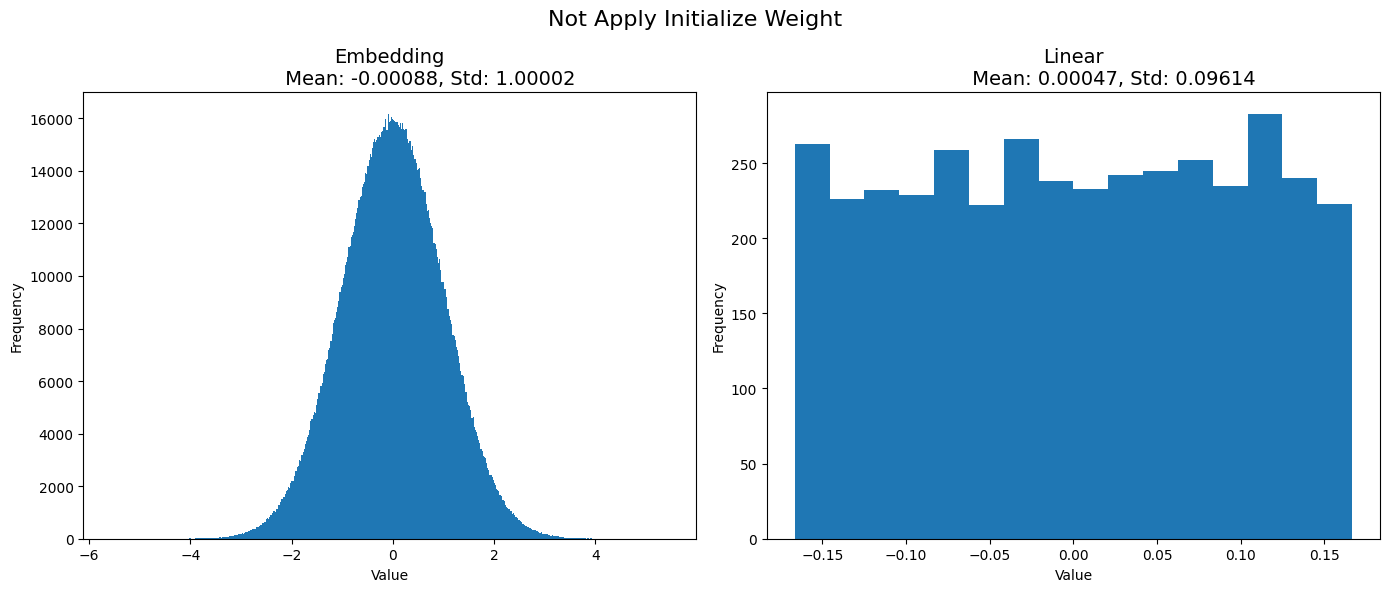

CPU times: total: 42.1 s
Wall time: 45.3 s


In [15]:
%%time
import matplotlib.pyplot as plt

def show_graph_init_weight(weight_dict, title):
    fig, axs = plt.subplots(1, len(weight_dict), figsize=(14, 6))

    for i, (param_name, param_value) in enumerate(weight_dict.items()):
        ax = axs[i]
        ax.hist(param_value, bins='fd')
        
        ax.set_title(f"{param_name}\n \
            Mean: {param_value.mean():.5f}, Std: {param_value.std():.5f}", fontsize=14)
        
        ax.set_xlabel("Value", fontsize=10)
        ax.set_ylabel("Frequency", fontsize=10)

    fig.suptitle(f"{title} Apply Initialize Weight", fontsize=16)
    plt.tight_layout()
    plt.show()
    
show_graph_init_weight(weight_dict_not, "Not")

Weight trong lớp nn.Embedding được khởi tạo theo phân phối chuẩn (Gaussian) với mean (trung bình) bằng 0 và độ lệch chuẩn (std) bằng 1. Đối với weight trong lớp nn.Linear, chúng được khởi tạo theo phân phối đều (uniform distribution) với mean bằng 0 và độ lệch chuẩn bằng 0.095.

In [16]:
class TransformerSequential_Have(nn.Module):
    def __init__(self, args):
        super().__init__()
        
        modules = [Embedding(args)]
        modules += [TransfomerBlock(args) for _ in range(args.n_layer)]
        modules.append(TransformerHead(args))
        
        self.layers = nn.Sequential(*modules)
        
        self.apply(self._init_weights)
        
    def forward(self, input_ids):
        return self.layers(input_ids)
    
    # New code
    # -----------------------------------------------------
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=.02)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=.02)
    # -----------------------------------------------------

Total Weight param of Embedding: 1809252
Total Weight param of Linear:    3888


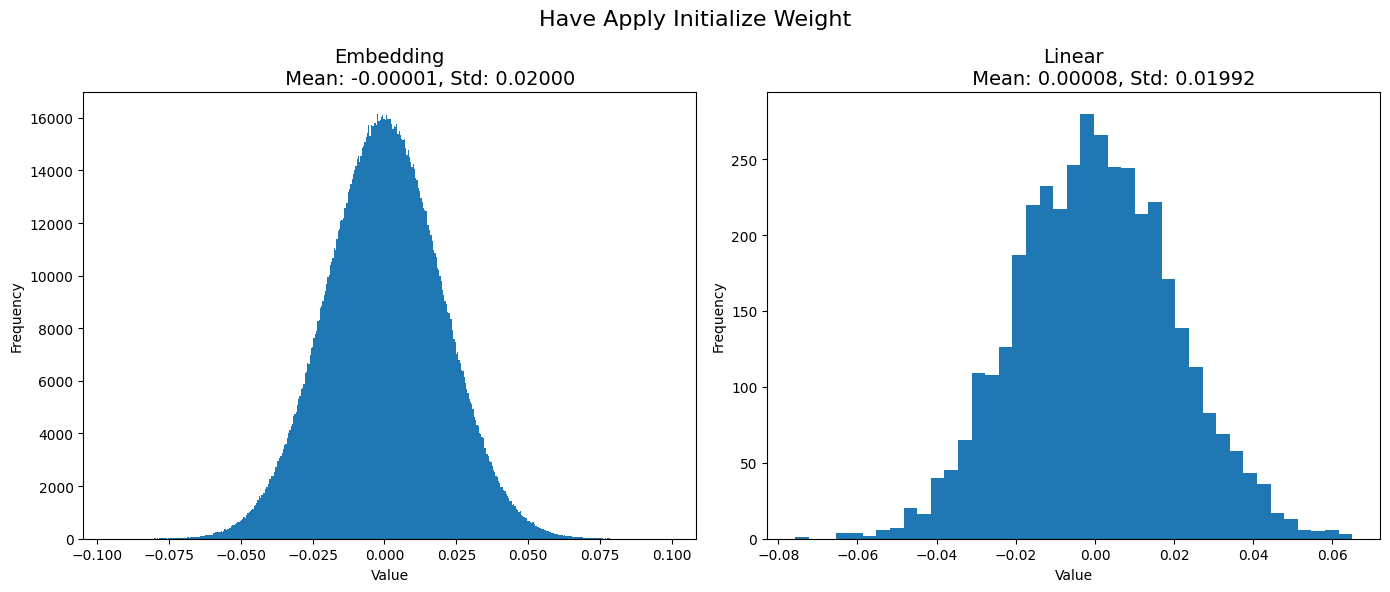

CPU times: total: 36.5 s
Wall time: 39.1 s


In [17]:
%%time
model_have = TransformerSequential_Have(args)

weight_dict_have = {}
for name, param in model_have.named_parameters():
    param = param.view(-1).detach()
    if name in weight_names.values():
        param_name = [key for key, value in weight_names.items() if value == name][0]
        weight_dict_have[param_name] = param
        
print("Total Weight param of Embedding:", len(weight_dict_have['Embedding']))
print("Total Weight param of Linear:   ", len(weight_dict_have['Linear']))        
show_graph_init_weight(weight_dict_have, "Have")

LLAMA2 chọn cách khởi tạo weight trong các lớp Embedding và Linear bằng phân phối Gaussian với giá trị trung bình là 0 và độ lệch chuẩn là 0.02.

Chúng ta hãy cùng xem xét kết quả output tại các layer để hiểu rõ hơn về lý do họ chọn cách thức khởi tạo weight này. 

In [19]:
def get_layers_output(model, input_ids, title):
    layers_output = []
    print(f"{title} Apply Initialize Weight:")
    for layer in model.layers:
        input_ids = layer(input_ids)
        
        layer_name = type(layer).__name__
        print(f"Output {layer_name}: {input_ids.shape}")

        layers_output.append((layer_name, input_ids.detach().numpy().flatten()))
        
    return layers_output

layers_output_not = get_layers_output(model_not, input_ids[0], 'Not')
print("")
layers_output_have = get_layers_output(model_have, input_ids[0], 'Have')

Not Apply Initialize Weight:
Output Embedding: torch.Size([1, 10, 36])
Output TransfomerBlock: torch.Size([1, 10, 36])
Output TransfomerBlock: torch.Size([1, 10, 36])
Output TransfomerBlock: torch.Size([1, 10, 36])
Output TransfomerBlock: torch.Size([1, 10, 36])
Output TransformerHead: torch.Size([1, 10, 50257])

Have Apply Initialize Weight:
Output Embedding: torch.Size([1, 10, 36])
Output TransfomerBlock: torch.Size([1, 10, 36])
Output TransfomerBlock: torch.Size([1, 10, 36])
Output TransfomerBlock: torch.Size([1, 10, 36])
Output TransfomerBlock: torch.Size([1, 10, 36])
Output TransformerHead: torch.Size([1, 10, 50257])


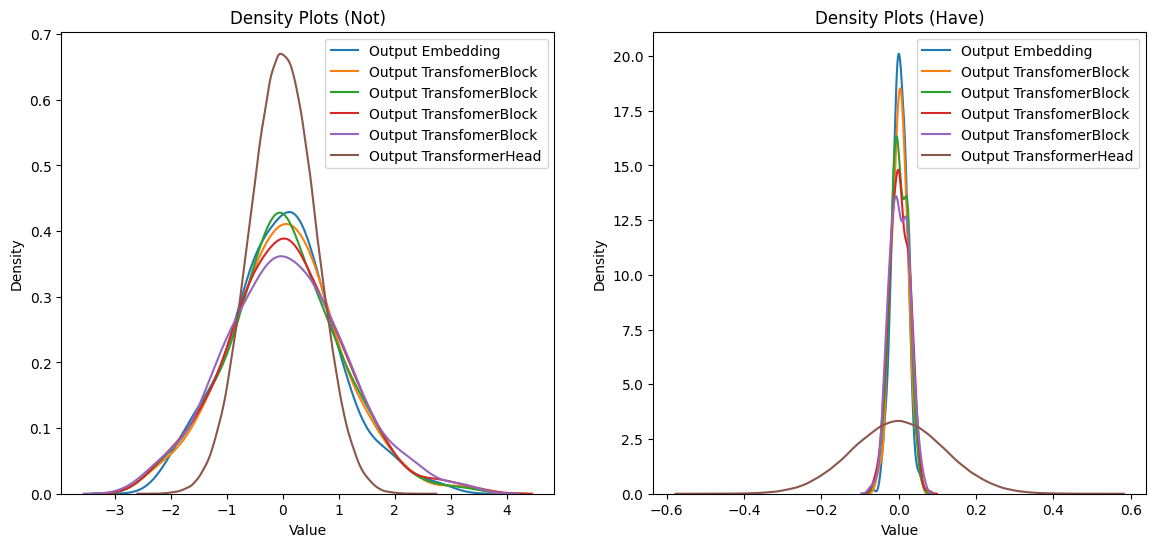

CPU times: total: 10.4 s
Wall time: 12.5 s


In [20]:
%%time
import seaborn as sns

def show_density_plots(layers_output, ax, title):
    for layer_name, layer_output in layers_output:
        sns.kdeplot(layer_output, ax=ax, label=f"Output {layer_name}")
        
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.legend()
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
show_density_plots(layers_output_not, axes[0], "Density Plots (Not)")
show_density_plots(layers_output_have, axes[1], "Density Plots (Have)")

plt.show()

Cả hai cách khởi tạo trọng số đều tuân theo phân phối Gaussian, dẫn đến output của các layer có phân phối tương tự. Tuy nhiên, với cách tiếp cận mặc định của PyTorch, output của lớp Embedding và Transformer Block thường có mean và std gần bằng nhau, trước khi giảm mạnh khi tiến đến lớp Transformer Head (lớp cuối cùng). LLAMA2 đã thay đổi cách tiếp cận này, tạo ra một dạng phân phối với độ lệch chuẩn tăng dần từ các lớp Embedding và Transformer Block và tăng mạnh khi tiếp cận lớp cuối cùng.

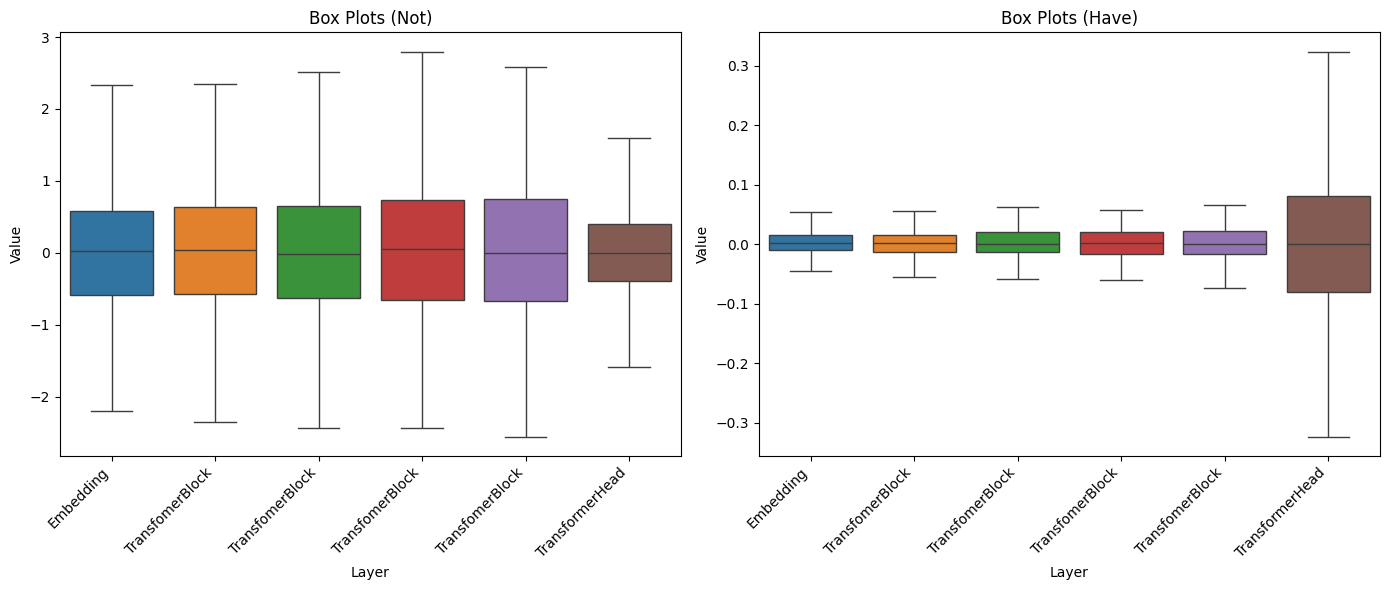

In [21]:
def show_box_plots(layers_output, ax, title):
    sns.boxplot(data=[data for _, data in layers_output], ax=ax, showfliers=False)
        
    ax.set_xlabel("Layer")
    ax.set_ylabel("Value")
    ax.set_title(title)
    
    x = range(len(layers_output))
    ax.set_xticks(x)
    
    ax.set_xticklabels([layer_name for layer_name, _ in layers_output], rotation=45, ha='right')
    
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
show_box_plots(layers_output_not, axes[0], "Box Plots (Not)")
show_box_plots(layers_output_have, axes[1], "Box Plots (Have)")

plt.tight_layout()
plt.show()

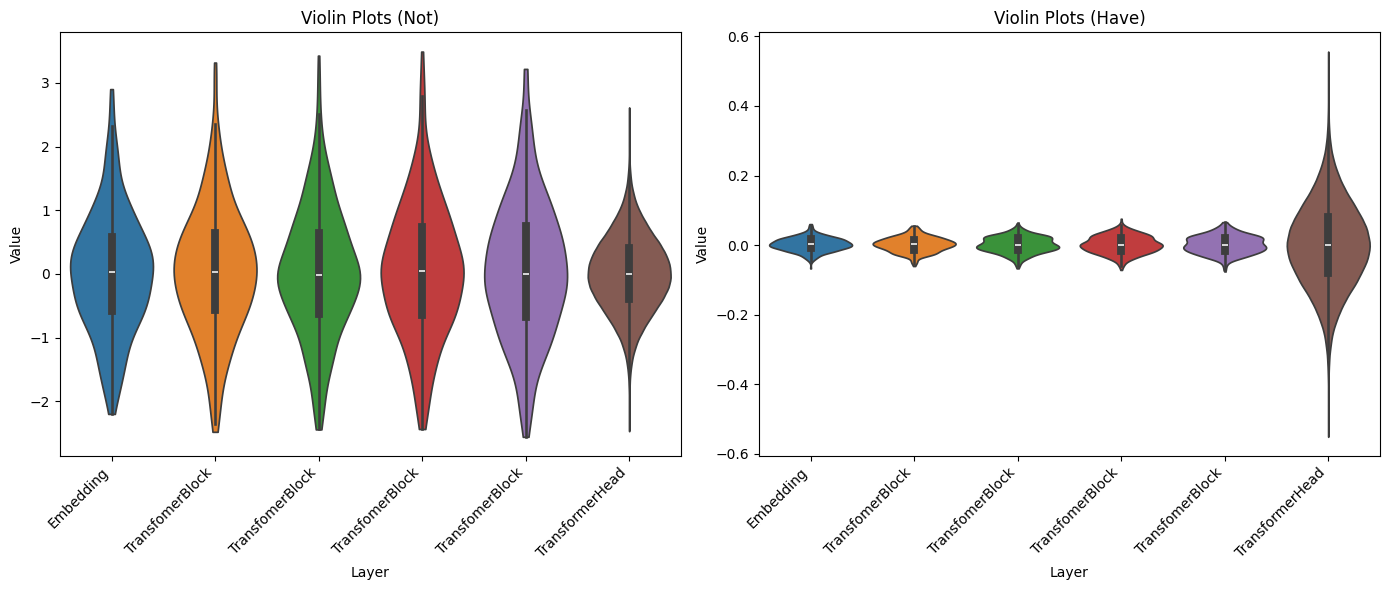

In [22]:
def show_violin_plots(layers_output, ax, title):
    sns.violinplot(data=[data for _, data in layers_output], ax=ax, inner='box', cut=0)
    
    ax.set_xlabel("Layer")
    ax.set_ylabel("Value")
    ax.set_title(title)        

    x = range(len(layers_output))
    ax.set_xticks(x)
    ax.set_xticklabels([layer_name for layer_name, _ in layers_output], rotation=45, ha='right')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
show_violin_plots(layers_output_not, axes[0], "Violin Plots (Not)")
show_violin_plots(layers_output_have, axes[1], "Violin Plots (Have)")

plt.tight_layout()
plt.show()

## Loss

In [23]:
class TransformerLoss(nn.Module):
    def __init__(self):
        super().__init__()

        self.loss_fct = nn.CrossEntropyLoss()
        
    def forward(self, logits, labels, shift_labels = True):
        
        # New code
        # ----------------------------------------
        if shift_labels:
            logits = logits[..., :-1, :].contiguous()
            labels = labels[..., 1:].contiguous()
        # ----------------------------------------
        
        logits = logits.view(-1, logits.shape[-1])
        labels = labels.view(-1)                    
                             
        loss = self.loss_fct(logits, labels)

        return loss
    
t_loss = TransformerLoss()
loss = t_loss(logits, input_ids)
loss

tensor(11.1590, grad_fn=<NllLossBackward0>)

Như đã đề cập trước đó, thay vì phải chia xb và yb ngay từ giai đoạn lấy dữ liệu, một cách tiếp cận khác là "shift labels" khi tính toán loss. Tôi chọn cách này vì trong code của LLAMA2, tôi thấy có một biến gọi là input_ids, cho thấy họ có thể đang áp dụng cách tiếp cận tương tự. Tuy nhiên, thực tế, bạn hoàn toàn có thể tách xb và yb ngay từ giai đoạn lấy dữ liệu nếu bạn cảm thấy phù hợp.

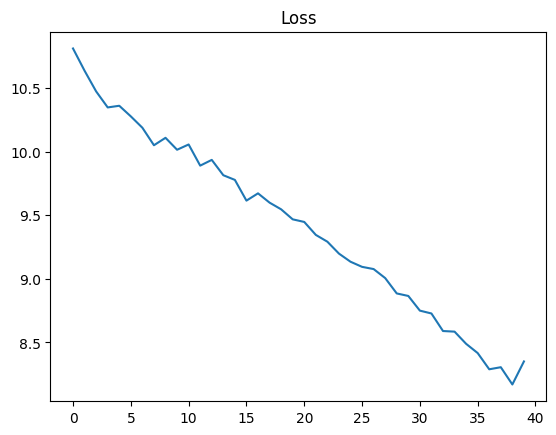

In [29]:
n_epochs = 10
learning_rate = .001

vocab_size = tokenizer.vocab_size
args = ModelArgs(vocab_size)
model = TransformerSequential_Have(args)
t_loss = TransformerLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
for epochi in range(n_epochs):
    for input_ids in data_loader:
        logits = model(input_ids)
        loss = t_loss(logits, input_ids)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
plt.plot(losses)
plt.title("Loss");

Vậy là chúng ta đã hoàn thành tất cả các bước cần thiết để chuẩn bị cho việc huấn luyện mô hình. Trong chương tiếp theo, chúng ta sẽ tập trung vào việc cài đặt các siêu tham số (hyperparameters) mà LLAMA2 đã sử dụng để huấn luyện mô hình trên một tập dữ liệu nhỏ để tiến hành thử nghiệm. Điều này sẽ giúp chúng ta có cái nhìn cụ thể hơn về cách họ điều chỉnh các tham số để đạt được hiệu suất tốt nhất trong môi trường dữ liệu có hạn chế. Thêm vào đó, việc thực hiện thử nghiệm trên một tập dữ liệu nhỏ sẽ giúp chúng ta nhanh chóng đánh giá hiệu suất của mô hình trước khi triển khai trên toàn bộ tập dữ liệu.